# Data Science Research Project A - Radio Frequency Communication Channel Model
## 1. Data Loading and preprocesing

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# Set random seed
seed = 22
np.random.seed(seed)
random.seed(seed)

# Set display options to prevent auto line wrapping
pd.set_option('display.expand_frame_repr', False)  

file_path = 'RFLFSODataFull.csv'  
data = pd.read_csv(file_path)

print("data info:")
print(data.info())
print("\ndata head:")
print(data.head())
print("\ndata distribution:")
print(data.describe())
print("\n SYNOPCode count:")
print(data['SYNOPCode'].value_counts())

X = data.drop(columns=['RFL_Att', 'FSO_Att'])
y = data['RFL_Att']

# Split training and test sets based on different weather condition levels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22, stratify=data['SYNOPCode'])

data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91379 entries, 0 to 91378
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   FSO_Att                91379 non-null  float64
 1   RFL_Att                91379 non-null  float64
 2   AbsoluteHumidity       91379 non-null  float64
 3   AbsoluteHumidityMax    91379 non-null  float64
 4   AbsoluteHumidityMin    91379 non-null  float64
 5   Distance               91379 non-null  float64
 6   Frequency              91379 non-null  int64  
 7   Particulate            91379 non-null  float64
 8   ParticulateMax         91379 non-null  float64
 9   ParticulateMin         91379 non-null  float64
 10  RainIntensity          91379 non-null  float64
 11  RainIntensityMax       91379 non-null  float64
 12  RainIntensityMin       91379 non-null  float64
 13  RelativeHumidity       91379 non-null  float64
 14  SYNOPCode              91379 non-null  int6

## 2. Method 1. Generic Random Forest model
### 2.1 Feature selection

In [2]:
def feature_selection_generic(X_train, y_train):
    print("\nProcessing Generic Model")
    
    # Perform One-hot encoding on SYNOPCode
    X_train = pd.get_dummies(X_train, columns=['SYNOPCode'], drop_first=True)

    # Initialise result lists
    results = []
    removed_features = []
    ordered_features = []  # List to store remaining features
    last_removed_feature = None  # To store the least important feature found in the previous round

    # Feature selection process
    iteration = 1  # Initialise iteration counter
    while X_train.shape[1] > 0:
        # Define the Random Forest model, using OOB score
        rf = RandomForestRegressor(n_estimators=50, oob_score=True, random_state=22)
        rf.fit(X_train, y_train)

        # Get feature importances
        importances = rf.feature_importances_
        least_important_feature_index = np.argmin(importances)

        # Calculate OOB RMSE and R² for the current model
        oob_pred = rf.oob_prediction_ 
        rmse = mean_squared_error(y_train, oob_pred, squared=False)
        r2 = r2_score(y_train, oob_pred)

        # Store results
        results.append((rmse, r2))
        least_important_feature = X_train.columns[least_important_feature_index]
        removed_features.append(least_important_feature)

        # Print model performance
        print(f"Iteration {iteration}: OOB RMSE = {rmse:.4f}, OOB R² = {r2:.4f}")

        # Print the number of remaining features based on iteration
        if iteration == 1:
            print(f"Remaining features: {X_train.shape[1]}")  # Show total feature count in the first round
        else:
            print(f"Removed feature: {last_removed_feature}. Remaining features: {X_train.shape[1]}")  # Show removed feature and remaining count in subsequent rounds
            
        last_removed_feature = least_important_feature  # Store the least important feature found in the previous round

        # Remove the least important feature
        X_train = X_train.drop(columns=[least_important_feature])

        # Add to the ordered_features list
        ordered_features.append(least_important_feature)

        iteration += 1  # Increment the iteration counter

    # Add the last remaining feature
    if X_train.shape[1] > 0:
        ordered_features.append(X_train.columns[0])  # Assuming only one feature remains at this point

    # Extract RMSE and R² values
    rmse_values = [result[0] for result in results]
    r2_values = [result[1] for result in results]

    # Plot the line chart
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot RMSE line chart
    ax1.set_xlabel('Removed Features', fontsize=14)
    ax1.set_ylabel('RMSE(dB)', color='tab:red', fontsize=14)
    ax1.plot(range(len(rmse_values)), rmse_values, color='tab:red', marker='o', label='RMSE')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Create a second y-axis to plot the R² line chart
    ax2 = ax1.twinx()
    ax2.set_ylabel('R²', color='tab:blue', fontsize=14)
    ax2.plot(range(len(r2_values)), r2_values, color='tab:blue', marker='o', label='R²')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Set x-axis ticks and labels
    ax1.set_xticks(range(len(rmse_values)))
    ax1.set_xticklabels(ordered_features, rotation=45, ha='right', fontsize=12)  

    # Add title and legend
    plt.title('Generic Model Performance for RF Attenuation', fontsize=16)
    # Set font size for x-axis ticks
    plt.xticks(fontsize=14) 
    fig.tight_layout() 
    plt.show()

    # Return the ordered_features list
    return ordered_features


Processing Generic Model
Iteration 1: OOB RMSE = 0.5463, OOB R² = 0.9747
Remaining features: 30
Iteration 2: OOB RMSE = 0.5474, OOB R² = 0.9746
Removed feature: SYNOPCode_3. Remaining features: 29
Iteration 3: OOB RMSE = 0.5459, OOB R² = 0.9747
Removed feature: SYNOPCode_7. Remaining features: 28
Iteration 4: OOB RMSE = 0.5467, OOB R² = 0.9747
Removed feature: SYNOPCode_4. Remaining features: 27
Iteration 5: OOB RMSE = 0.5464, OOB R² = 0.9747
Removed feature: SYNOPCode_6. Remaining features: 26
Iteration 6: OOB RMSE = 0.5432, OOB R² = 0.9750
Removed feature: SYNOPCode_5. Remaining features: 25
Iteration 7: OOB RMSE = 0.5472, OOB R² = 0.9746
Removed feature: SYNOPCode_8. Remaining features: 24
Iteration 8: OOB RMSE = 0.5441, OOB R² = 0.9749
Removed feature: WindDirection. Remaining features: 23
Iteration 9: OOB RMSE = 0.5463, OOB R² = 0.9747
Removed feature: WindSpeedMin. Remaining features: 22
Iteration 10: OOB RMSE = 0.5424, OOB R² = 0.9750
Removed feature: WindSpeedMax. Remaining fe

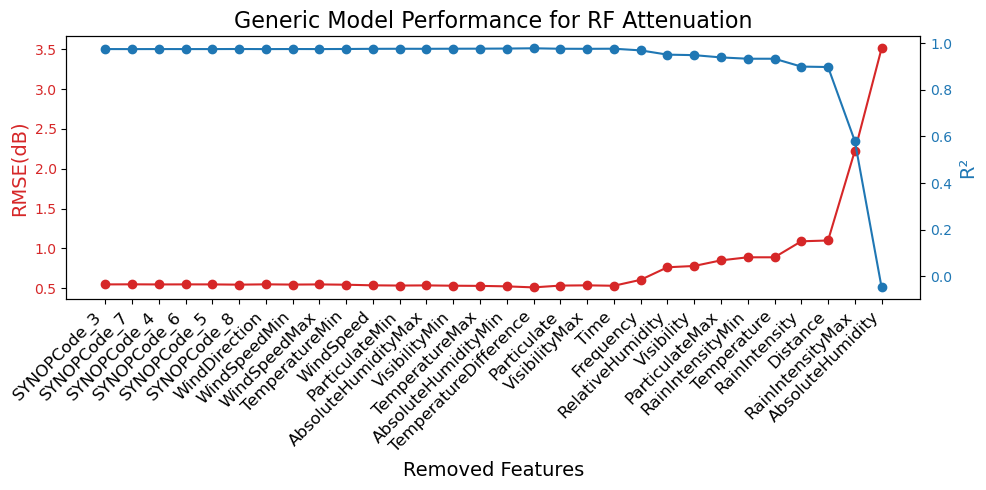

In [3]:
generic_ordered_feature = feature_selection_generic(X_train, y_train)

In [5]:
generic_selected_features = generic_ordered_feature[-11:]
print(generic_selected_features)

['Time', 'Frequency', 'RelativeHumidity', 'Visibility', 'ParticulateMax', 'RainIntensityMin', 'Temperature', 'RainIntensity', 'Distance', 'RainIntensityMax', 'AbsoluteHumidity']


### 2.2 Hyperparameter optimisation

In [6]:
def tune_hyperparameters(X_train, y_train, selected_features):
    
    # Train using the selected features passed in
    X_train_selected = X_train[selected_features]
    
    # Define the Random Forest model
    rf = RandomForestRegressor(oob_score=True, random_state=22)

    # Hyperparameter tuning
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    }
    
    # Perform hyperparameter tuning using cross-validation
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_selected, y_train)

    # Get the best hyperparameter combination
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")

    return best_params

In [7]:
# Use the 11 most important features for hyperparameter tuning
best_params = tune_hyperparameters(X_train, y_train, generic_selected_features)

/Users/elise/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'max_depth': None, 'n_estimators': 200}


### 2.3 Train and evalute the generic RF model with the best hyperparameter values

In [8]:
def train_and_evaluate_best_generic_rf_model(X_train, y_train, X_test, y_test, selected_features, best_params):
   
    # Train using the selected features passed in
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    # Define the model using the best hyperparameter combination
    generic_RF_model = RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        oob_score=True,
        random_state=22
    )

    # Train the model on the training set
    generic_RF_model.fit(X_train_selected, y_train)
    
    # Make predictions on the training set
    y_train_pred = generic_RF_model.predict(X_train_selected)

    # Calculate RMSE and R² for the training set
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_r2 = r2_score(y_train, y_train_pred)

    # Make predictions on the test set
    y_test_pred = generic_RF_model.predict(X_test_selected)
    
    # Calculate RMSE and R² for the test set
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
    r2_test = r2_score(y_test, y_test_pred)
    
    # Print the results for the training and test sets
    print(f"Training RMSE of generic RF model: {train_rmse:.4f}")
    print(f"Training R² of generic RF model: {train_r2:.4f}")
    print(f"Test RMSE of generic RF model: {rmse_test:.4f}")
    print(f"Test R² of generic RF model: {r2_test:.4f}")

    
    # Store predictions and actual values by condition
    condition_predictions = {0: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
    actual_values = {0: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
    
    # Iterate over X_test
    for index, row in X_test.iterrows():
        condition = row['SYNOPCode']
        if condition in condition_predictions:
            condition_predictions[condition].append(y_test_pred[X_test.index.get_loc(index)])  # Get the corresponding prediction value
            actual_values[condition].append(y_test.iloc[X_test.index.get_loc(index)])  # Get the corresponding actual value

    # Calculate RMSE and R² for each weather condition
    gene_condition_results = {}
    
    # Weather condition mapping
    condition_map = {
        0: 'Clear',
        3: 'Dust Storm',
        4: 'Fog',
        5: 'Drizzle',
        6: 'Rain',
        7: 'Snow',
        8: 'Showers'
    }
    
    for condition in condition_predictions.keys():
        if condition_predictions[condition]:  
            rmse = np.sqrt(mean_squared_error(actual_values[condition], condition_predictions[condition]))
            r2 = r2_score(actual_values[condition], condition_predictions[condition])
            
            # Store RMSE and R² in the dictionary
            gene_condition_results[condition_map[condition]] = {
                'RMSE': rmse,
                'R²': r2
            }

            # Print the results
            print(f' Weather condition {condition_map[condition]}: RMSE = {rmse:.4f}, R² = {r2:.4f}')

    return rmse_test, r2_test, gene_condition_results

In [9]:
# Train the generic model with the best parameters
rmse_test, r2_test, gene_condition_results = train_and_evaluate_best_generic_rf_model(X_train, y_train, X_test, y_test, generic_selected_features, best_params)

Training RMSE of generic RF model: 0.1918
Training R² of generic RF model: 0.9969
Test RMSE of generic RF model: 0.4824
Test R² of generic RF model: 0.9804
 Weather condition Clear: RMSE = 0.3069, R² = 0.9854
 Weather condition Dust Storm: RMSE = 0.2729, R² = 0.9915
 Weather condition Fog: RMSE = 0.2519, R² = 0.9747
 Weather condition Drizzle: RMSE = 0.4455, R² = 0.9758
 Weather condition Rain: RMSE = 0.7166, R² = 0.9693
 Weather condition Snow: RMSE = 0.3837, R² = 0.9204
 Weather condition Showers: RMSE = 0.9774, R² = 0.9035


From the hyperpararmeter tuning in generic model, we find the best hyperparameters are: {'max_depth': 20, 'n_estimators': 200}. So we will use it as the model structure.

## 3. Method 2. Specific Random Forest models
### 3.1 Feature selection for each weather condition model

In [10]:
def feature_selection_for_weather(X_train, y_train, synop_code, condition):
    
    print(f"\nProcessing SYNOP Code: {synop_code} ({condition})")

    # Initialise result lists
    results = []
    removed_features = []
    ordered_features = []  # Used to store the remaining features
    last_removed_feature = None  # Used to store the least important feature from the previous iteration

    # Feature selection process
    iteration = 1  # Initialise iteration counter
    while X_train.shape[1] > 0:
        # Define random forest model using OOB score
        rf = RandomForestRegressor(n_estimators=50, oob_score=True, random_state=22)
        rf.fit(X_train, y_train)

        # Get feature importances
        importances = rf.feature_importances_
        least_important_feature_index = np.argmin(importances)

        # Calculate the current model's RMSE and R² using OOB score
        oob_pred = rf.oob_prediction_  
        rmse = mean_squared_error(y_train, oob_pred, squared=False)
        r2 = r2_score(y_train, oob_pred)

        # Store the results
        results.append((rmse, r2))
        least_important_feature = X_train.columns[least_important_feature_index]
        removed_features.append(least_important_feature)

        # Print current model performance
        print(f"Iteration {iteration}: RMSE = {rmse:.4f}, R² = {r2:.4f}")

        # Print the feature count based on the iteration number
        if iteration == 1:
            print(f"Remaining features: {X_train.shape[1]}")  # Show total number of features in the first round
        else:
            print(f"Removed feature: {last_removed_feature}. Remaining features: {X_train.shape[1]}")  # Show removed feature and remaining features in subsequent rounds

        last_removed_feature = least_important_feature  # Store the least important feature from the previous round

        # Remove the least important feature
        X_train = X_train.drop(columns=[least_important_feature])

        # Add the removed feature to the ordered_features list
        ordered_features.append(least_important_feature)

        iteration += 1  # Increment iteration counter

    # Add the last remaining feature
    if X_train.shape[1] > 0:
        ordered_features.append(X_train.columns[0])  

    # Extract RMSE and R² values
    rmse_values = [result[0] for result in results]
    r2_values = [result[1] for result in results]

    # Plot the line charts
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot RMSE line chart
    ax1.set_xlabel('Removed Features', fontsize=14)  
    ax1.set_ylabel('RMSE(dB)', color='tab:red', fontsize=14)  
    ax1.plot(range(len(rmse_values)), rmse_values, color='tab:red', marker='o', label='RMSE')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Create second y-axis to plot R² line chart
    ax2 = ax1.twinx()
    ax2.set_ylabel('R²', color='tab:blue', fontsize=14)  
    ax2.plot(range(len(r2_values)), r2_values, color='tab:blue', marker='o', label='R²')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Set x-axis ticks and labels
    ax1.set_xticks(range(len(rmse_values)))
    ax1.set_xticklabels(ordered_features, rotation=45, ha='right', fontsize=12)  

    # Add title and legend
    plt.title(f'{condition} Model Performance for RF Attenuation', fontsize=16)  
    fig.tight_layout() 
    plt.show()

    # Return the ordered_features list
    return ordered_features

In [11]:
# Split the training set into different weather types based on 'SYNOPCode'
# Clear
X_train_clear = X_train[X_train['SYNOPCode'] == 0]
y_train_clear = y_train[X_train['SYNOPCode'] == 0]

# Dust Storm
X_train_dust_storm = X_train[X_train['SYNOPCode'] == 3]
y_train_dust_storm = y_train[X_train['SYNOPCode'] == 3]

# Fog
X_train_fog = X_train[X_train['SYNOPCode'] == 4]
y_train_fog = y_train[X_train['SYNOPCode'] == 4]

# Drizzle
X_train_drizzle = X_train[X_train['SYNOPCode'] == 5]
y_train_drizzle = y_train[X_train['SYNOPCode'] == 5]

# Rain
X_train_rain = X_train[X_train['SYNOPCode'] == 6]
y_train_rain = y_train[X_train['SYNOPCode'] == 6]

# Snow
X_train_snow = X_train[X_train['SYNOPCode'] == 7]
y_train_snow = y_train[X_train['SYNOPCode'] == 7]

# Showers
X_train_showers = X_train[X_train['SYNOPCode'] == 8]
y_train_showers = y_train[X_train['SYNOPCode'] == 8]


Processing SYNOP Code: 0 (Clear)
Iteration 1: RMSE = 0.4311, R² = 0.9717
Remaining features: 24
Iteration 2: RMSE = 0.4248, R² = 0.9725
Removed feature: RainIntensityMax. Remaining features: 23
Iteration 3: RMSE = 0.4331, R² = 0.9714
Removed feature: RainIntensityMin. Remaining features: 22
Iteration 4: RMSE = 0.4402, R² = 0.9705
Removed feature: ParticulateMax. Remaining features: 21
Iteration 5: RMSE = 0.4259, R² = 0.9723
Removed feature: RainIntensity. Remaining features: 20
Iteration 6: RMSE = 0.4224, R² = 0.9728
Removed feature: ParticulateMin. Remaining features: 19
Iteration 7: RMSE = 0.4310, R² = 0.9717
Removed feature: Particulate. Remaining features: 18
Iteration 8: RMSE = 0.4329, R² = 0.9714
Removed feature: WindSpeed. Remaining features: 17
Iteration 9: RMSE = 0.4234, R² = 0.9727
Removed feature: WindDirection. Remaining features: 16
Iteration 10: RMSE = 0.4377, R² = 0.9708
Removed feature: WindSpeedMin. Remaining features: 15
Iteration 11: RMSE = 0.4328, R² = 0.9715
Remov

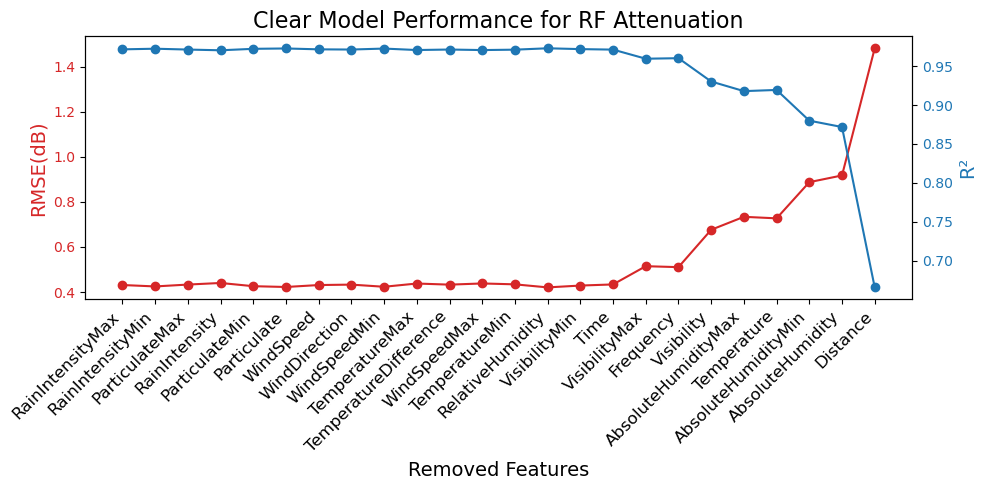

In [12]:
ordered_features_clear = feature_selection_for_weather(X_train_clear.drop(columns=['SYNOPCode']), y_train_clear, 0, 'Clear')

In [13]:
# Extract the last 9 features and train the model
clear_features = ordered_features_clear[-9:]
print(clear_features)

['Time', 'VisibilityMax', 'Frequency', 'Visibility', 'AbsoluteHumidityMax', 'Temperature', 'AbsoluteHumidityMin', 'AbsoluteHumidity', 'Distance']



Processing SYNOP Code: 3 (Dust Storm)
Iteration 1: RMSE = 0.6021, R² = 0.9602
Remaining features: 24
Iteration 2: RMSE = 0.5649, R² = 0.9649
Removed feature: Particulate. Remaining features: 23
Iteration 3: RMSE = 0.6214, R² = 0.9576
Removed feature: ParticulateMax. Remaining features: 22
Iteration 4: RMSE = 0.5675, R² = 0.9646
Removed feature: ParticulateMin. Remaining features: 21
Iteration 5: RMSE = 0.6192, R² = 0.9579
Removed feature: RainIntensity. Remaining features: 20
Iteration 6: RMSE = 0.6283, R² = 0.9566
Removed feature: RainIntensityMax. Remaining features: 19
Iteration 7: RMSE = 0.6061, R² = 0.9596
Removed feature: RainIntensityMin. Remaining features: 18
Iteration 8: RMSE = 0.5770, R² = 0.9634
Removed feature: WindSpeed. Remaining features: 17
Iteration 9: RMSE = 0.6044, R² = 0.9599
Removed feature: WindSpeedMin. Remaining features: 16
Iteration 10: RMSE = 0.5743, R² = 0.9638
Removed feature: WindSpeedMax. Remaining features: 15
Iteration 11: RMSE = 0.6021, R² = 0.9602
R

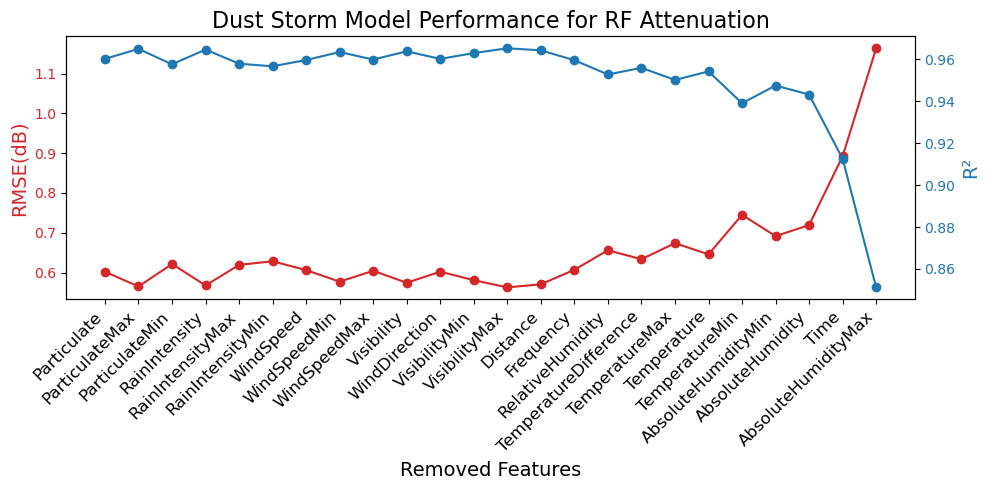

In [14]:
# Dust Storm
ordered_features_dust_storm = feature_selection_for_weather(X_train_dust_storm.drop(columns=['SYNOPCode']), y_train_dust_storm, 3, 'Dust Storm')

In [15]:
dust_storm_features = ordered_features_dust_storm[-12:]
print(dust_storm_features)

['VisibilityMax', 'Distance', 'Frequency', 'RelativeHumidity', 'TemperatureDifference', 'TemperatureMax', 'Temperature', 'TemperatureMin', 'AbsoluteHumidityMin', 'AbsoluteHumidity', 'Time', 'AbsoluteHumidityMax']



Processing SYNOP Code: 4 (Fog)
Iteration 1: RMSE = 0.5522, R² = 0.8925
Remaining features: 24
Iteration 2: RMSE = 0.5506, R² = 0.8931
Removed feature: WindSpeed. Remaining features: 23
Iteration 3: RMSE = 0.5542, R² = 0.8917
Removed feature: WindDirection. Remaining features: 22
Iteration 4: RMSE = 0.5593, R² = 0.8897
Removed feature: Particulate. Remaining features: 21
Iteration 5: RMSE = 0.5600, R² = 0.8894
Removed feature: WindSpeedMin. Remaining features: 20
Iteration 6: RMSE = 0.5595, R² = 0.8896
Removed feature: Visibility. Remaining features: 19
Iteration 7: RMSE = 0.5378, R² = 0.8980
Removed feature: Distance. Remaining features: 18
Iteration 8: RMSE = 0.5550, R² = 0.8914
Removed feature: WindSpeedMax. Remaining features: 17
Iteration 9: RMSE = 0.5446, R² = 0.8954
Removed feature: VisibilityMin. Remaining features: 16
Iteration 10: RMSE = 0.5561, R² = 0.8910
Removed feature: Frequency. Remaining features: 15
Iteration 11: RMSE = 0.5569, R² = 0.8907
Removed feature: Particulate

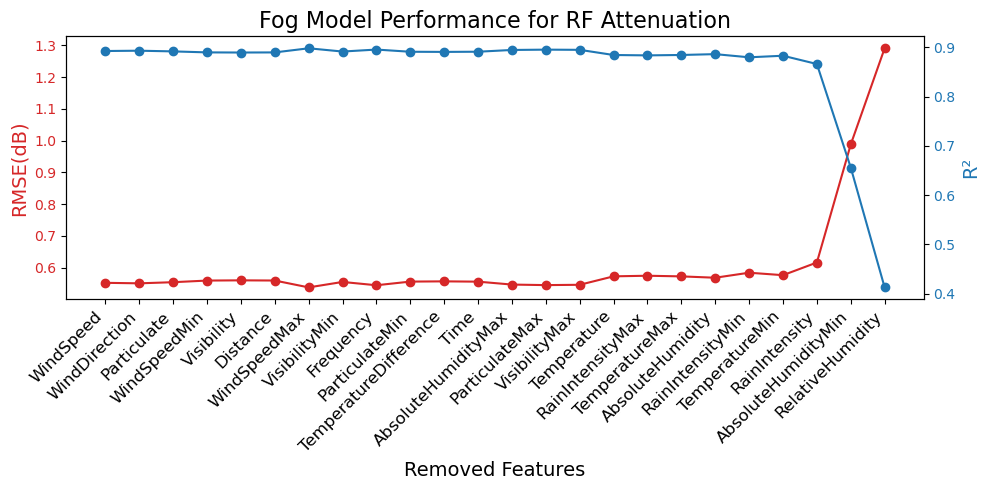

In [16]:
# Fog
ordered_features_fog = feature_selection_for_weather(X_train_fog.drop(columns=['SYNOPCode']), y_train_fog, 4, 'Fog')

In [17]:
fog_features = ordered_features_fog[-4:] # 10
print(fog_features)

['TemperatureMin', 'RainIntensity', 'AbsoluteHumidityMin', 'RelativeHumidity']



Processing SYNOP Code: 5 (Drizzle)
Iteration 1: RMSE = 0.6474, R² = 0.9498
Remaining features: 24
Iteration 2: RMSE = 0.6475, R² = 0.9498
Removed feature: WindDirection. Remaining features: 23
Iteration 3: RMSE = 0.6501, R² = 0.9494
Removed feature: WindSpeedMin. Remaining features: 22
Iteration 4: RMSE = 0.6401, R² = 0.9509
Removed feature: TemperatureMin. Remaining features: 21
Iteration 5: RMSE = 0.6379, R² = 0.9512
Removed feature: WindSpeedMax. Remaining features: 20
Iteration 6: RMSE = 0.6403, R² = 0.9509
Removed feature: WindSpeed. Remaining features: 19
Iteration 7: RMSE = 0.6371, R² = 0.9514
Removed feature: VisibilityMax. Remaining features: 18
Iteration 8: RMSE = 0.6371, R² = 0.9514
Removed feature: Particulate. Remaining features: 17
Iteration 9: RMSE = 0.6214, R² = 0.9537
Removed feature: TemperatureMax. Remaining features: 16
Iteration 10: RMSE = 0.6249, R² = 0.9532
Removed feature: ParticulateMin. Remaining features: 15
Iteration 11: RMSE = 0.6494, R² = 0.9495
Removed f

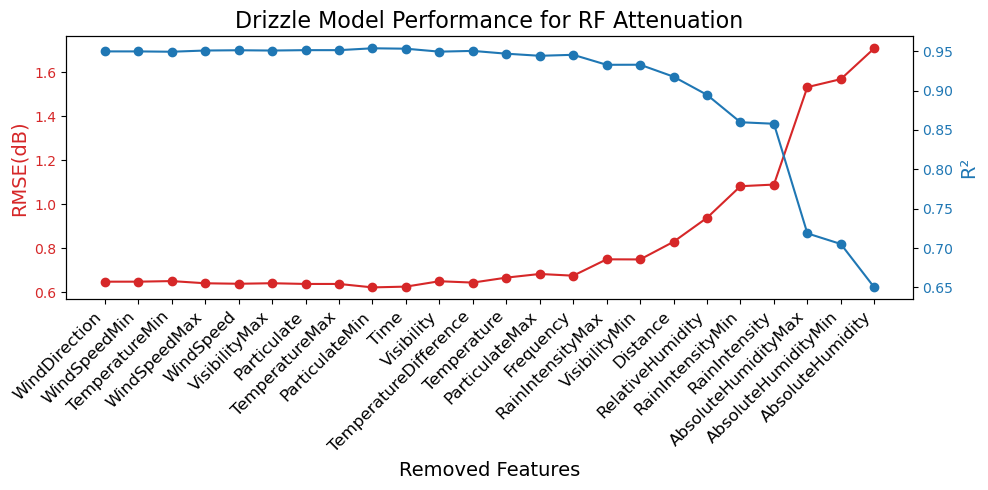

In [18]:
# Drizzle
ordered_features_drizzle = feature_selection_for_weather(X_train_drizzle.drop(columns=['SYNOPCode']), y_train_drizzle, 5, 'Drizzle')

In [19]:
drizzle_features = ordered_features_drizzle[-10:] # -15
print(drizzle_features)

['Frequency', 'RainIntensityMax', 'VisibilityMin', 'Distance', 'RelativeHumidity', 'RainIntensityMin', 'RainIntensity', 'AbsoluteHumidityMax', 'AbsoluteHumidityMin', 'AbsoluteHumidity']



Processing SYNOP Code: 6 (Rain)
Iteration 1: RMSE = 0.8121, R² = 0.9592
Remaining features: 24
Iteration 2: RMSE = 0.8068, R² = 0.9597
Removed feature: WindDirection. Remaining features: 23
Iteration 3: RMSE = 0.8023, R² = 0.9602
Removed feature: WindSpeedMin. Remaining features: 22
Iteration 4: RMSE = 0.8025, R² = 0.9601
Removed feature: WindSpeedMax. Remaining features: 21
Iteration 5: RMSE = 0.7966, R² = 0.9607
Removed feature: TemperatureMin. Remaining features: 20
Iteration 6: RMSE = 0.7881, R² = 0.9616
Removed feature: WindSpeed. Remaining features: 19
Iteration 7: RMSE = 0.7807, R² = 0.9623
Removed feature: TemperatureMax. Remaining features: 18
Iteration 8: RMSE = 0.7784, R² = 0.9625
Removed feature: Particulate. Remaining features: 17
Iteration 9: RMSE = 0.7687, R² = 0.9634
Removed feature: AbsoluteHumidityMin. Remaining features: 16
Iteration 10: RMSE = 0.9093, R² = 0.9488
Removed feature: Frequency. Remaining features: 15
Iteration 11: RMSE = 0.9065, R² = 0.9492
Removed fea

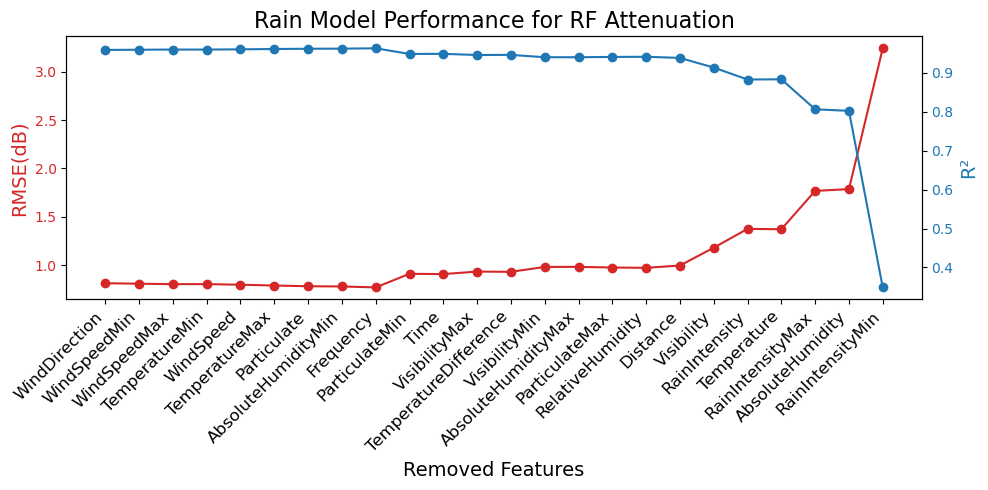

In [20]:
# Rain
ordered_features_rain = feature_selection_for_weather(X_train_rain.drop(columns=['SYNOPCode']), y_train_rain, 6, 'Rain')

In [21]:
rain_features = ordered_features_rain[-16:] #8/7
print(rain_features)

['Frequency', 'ParticulateMin', 'Time', 'VisibilityMax', 'TemperatureDifference', 'VisibilityMin', 'AbsoluteHumidityMax', 'ParticulateMax', 'RelativeHumidity', 'Distance', 'Visibility', 'RainIntensity', 'Temperature', 'RainIntensityMax', 'AbsoluteHumidity', 'RainIntensityMin']



Processing SYNOP Code: 7 (Snow)
Iteration 1: RMSE = 0.4145, R² = 0.9329
Remaining features: 24
Iteration 2: RMSE = 0.4108, R² = 0.9341
Removed feature: WindSpeed. Remaining features: 23
Iteration 3: RMSE = 0.4102, R² = 0.9343
Removed feature: WindSpeedMin. Remaining features: 22
Iteration 4: RMSE = 0.4073, R² = 0.9352
Removed feature: Distance. Remaining features: 21
Iteration 5: RMSE = 0.3980, R² = 0.9381
Removed feature: WindDirection. Remaining features: 20
Iteration 6: RMSE = 0.4010, R² = 0.9372
Removed feature: Temperature. Remaining features: 19
Iteration 7: RMSE = 0.3911, R² = 0.9402
Removed feature: VisibilityMax. Remaining features: 18
Iteration 8: RMSE = 0.3949, R² = 0.9391
Removed feature: TemperatureMax. Remaining features: 17
Iteration 9: RMSE = 0.4033, R² = 0.9365
Removed feature: Visibility. Remaining features: 16
Iteration 10: RMSE = 0.3990, R² = 0.9378
Removed feature: ParticulateMax. Remaining features: 15
Iteration 11: RMSE = 0.4309, R² = 0.9275
Removed feature: Fre

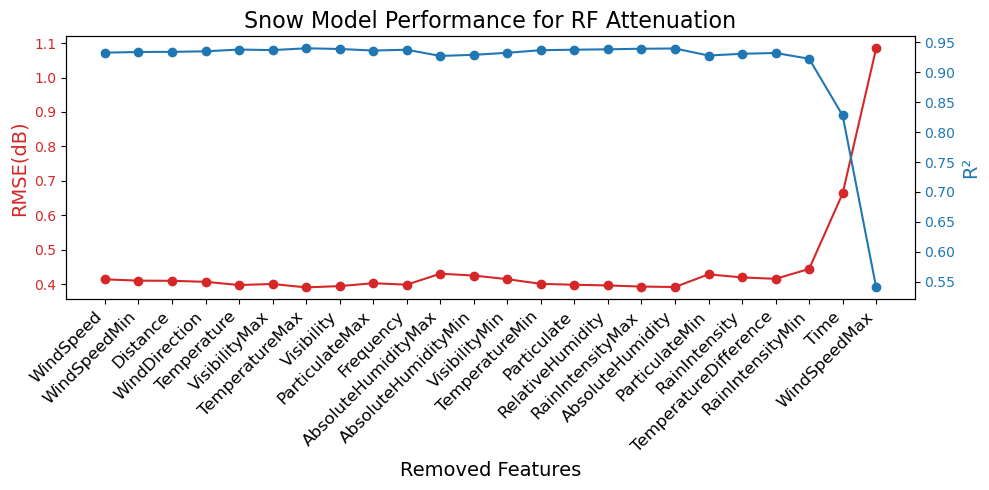

In [22]:
# Snow
ordered_features_snow = feature_selection_for_weather(X_train_snow.drop(columns=['SYNOPCode']), y_train_snow, 7, 'Snow')

In [23]:
snow_features = ordered_features_snow[-7:]
print(snow_features)

['AbsoluteHumidity', 'ParticulateMin', 'RainIntensity', 'TemperatureDifference', 'RainIntensityMin', 'Time', 'WindSpeedMax']



Processing SYNOP Code: 8 (Showers)
Iteration 1: RMSE = 0.9966, R² = 0.8929
Remaining features: 24
Iteration 2: RMSE = 0.9748, R² = 0.8975
Removed feature: WindDirection. Remaining features: 23
Iteration 3: RMSE = 0.9881, R² = 0.8947
Removed feature: TemperatureMax. Remaining features: 22
Iteration 4: RMSE = 0.9853, R² = 0.8953
Removed feature: WindSpeed. Remaining features: 21
Iteration 5: RMSE = 0.9725, R² = 0.8980
Removed feature: TemperatureMin. Remaining features: 20
Iteration 6: RMSE = 0.9612, R² = 0.9003
Removed feature: Time. Remaining features: 19
Iteration 7: RMSE = 0.9972, R² = 0.8927
Removed feature: WindSpeedMax. Remaining features: 18
Iteration 8: RMSE = 0.9695, R² = 0.8986
Removed feature: WindSpeedMin. Remaining features: 17
Iteration 9: RMSE = 0.9774, R² = 0.8969
Removed feature: TemperatureDifference. Remaining features: 16
Iteration 10: RMSE = 0.9948, R² = 0.8932
Removed feature: Particulate. Remaining features: 15
Iteration 11: RMSE = 0.9906, R² = 0.8941
Removed fea

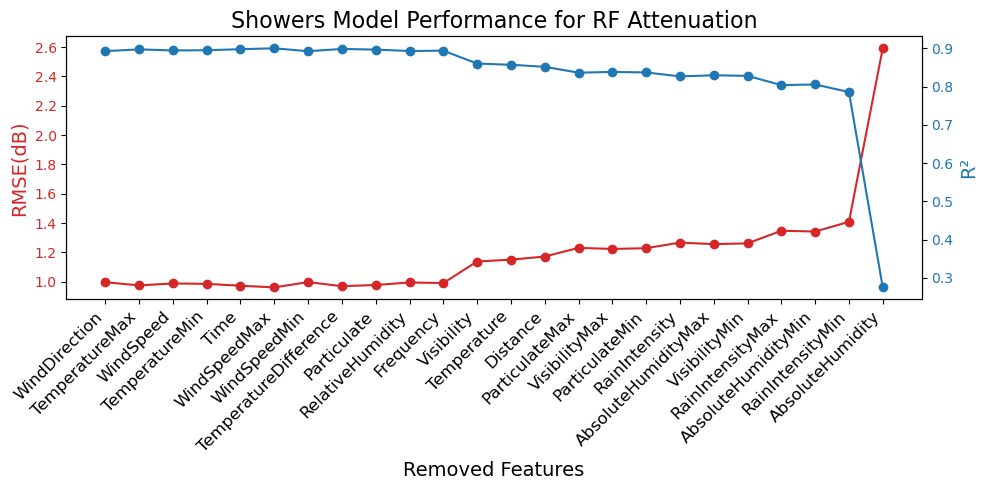

In [24]:
# Showers
ordered_features_showers = feature_selection_for_weather(X_train_showers.drop(columns=['SYNOPCode']), y_train_showers, 8, 'Showers')

In [25]:
showers_features = ordered_features_showers[-14:]
print(showers_features)

['Frequency', 'Visibility', 'Temperature', 'Distance', 'ParticulateMax', 'VisibilityMax', 'ParticulateMin', 'RainIntensity', 'AbsoluteHumidityMax', 'VisibilityMin', 'RainIntensityMax', 'AbsoluteHumidityMin', 'RainIntensityMin', 'AbsoluteHumidity']


### 3.2 Hyperparameter optimisation and Model training with important features for specific models

In [26]:
def train_rf_model(X_train, y_train, feature_list, condition):
    
    # Select features using the provided feature list
    X_train_selected = X_train[feature_list]

    # Define the Random Forest model
    rf_model = RandomForestRegressor(oob_score=True, random_state=22)

    # Hyperparameter tuning
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    }

    # Perform hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

    # Run the grid search for hyperparameter tuning
    grid_search.fit(X_train_selected, y_train)

    # Get the best model from the grid search
    best_model = grid_search.best_estimator_
    
    # Predict on the training set using the best model
    y_train_pred = best_model.predict(X_train_selected)

    # Calculate RMSE and R² for the training set
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_r2 = r2_score(y_train, y_train_pred)

    # Print the training performance metrics
    print(f"Training Performance for {condition}: RMSE = {train_rmse:.4f}, R² = {train_r2:.4f}")

    # Perform cross-validation with the best model
    cv_rmse = cross_val_score(best_model, X_train_selected, y_train, cv=5, scoring='neg_root_mean_squared_error')
    cv_r2 = cross_val_score(best_model, X_train_selected, y_train, cv=5, scoring='r2')

    # Calculate average RMSE and R² from cross-validation
    avg_rmse = -cv_rmse.mean()  # Convert negative score to normal RMSE
    avg_r2 = cv_r2.mean()

    # Print the cross-validation performance metrics
    print(f"Model Performance for {condition} (Cross-Validation): RMSE = {avg_rmse:.4f}, R² = {avg_r2:.4f}")

    # Retrain the model on the entire training set with the best hyperparameters
    final_model = grid_search.best_estimator_
    final_model.fit(X_train_selected, y_train)

    # Save the best model in the dictionary
    models[condition] = final_model

    # Return the best hyperparameters
    print(f"Best parameters for {condition}: {grid_search.best_params_}")

# Define the models dictionary
models = {}

In [27]:
# Clear
train_rf_model(X_train_clear, y_train_clear, clear_features, 'Clear')

# Dust Storm
train_rf_model(X_train_dust_storm, y_train_dust_storm, dust_storm_features, 'Dust Storm')

# Fog
train_rf_model(X_train_fog, y_train_fog, fog_features, 'Fog')

# Drizzle
train_rf_model(X_train_drizzle, y_train_drizzle, drizzle_features, 'Drizzle')

# Rain
train_rf_model(X_train_rain, y_train_rain, rain_features, 'Rain')

# Snow
train_rf_model(X_train_snow, y_train_snow, snow_features, 'Snow')

# Showers
train_rf_model(X_train_showers, y_train_showers, showers_features, 'Showers')

Training Performance for Clear: RMSE = 0.1589, R² = 0.9962
Model Performance for Clear (Cross-Validation): RMSE = 0.4509, R² = 0.9686
Best parameters for Clear: {'max_depth': None, 'n_estimators': 100}
Training Performance for Dust Storm: RMSE = 0.2399, R² = 0.9937
Model Performance for Dust Storm (Cross-Validation): RMSE = 0.5487, R² = 0.9600
Best parameters for Dust Storm: {'max_depth': 10, 'n_estimators': 100}
Training Performance for Fog: RMSE = 0.2224, R² = 0.9826
Model Performance for Fog (Cross-Validation): RMSE = 0.5600, R² = 0.8701
Best parameters for Fog: {'max_depth': 10, 'n_estimators': 100}
Training Performance for Drizzle: RMSE = 0.2397, R² = 0.9931
Model Performance for Drizzle (Cross-Validation): RMSE = 0.6446, R² = 0.9492
Best parameters for Drizzle: {'max_depth': None, 'n_estimators': 200}
Training Performance for Rain: RMSE = 0.2734, R² = 0.9954
Model Performance for Rain (Cross-Validation): RMSE = 0.7869, R² = 0.9615
Best parameters for Rain: {'max_depth': 20, 'n_es

### 3.3 Combine and evaluate 7 different weather condition models using the test set

In [28]:
# Mapping condition codes to weather conditions
condition_map = {
    0: 'Clear',
    3: 'Dust Storm',
    4: 'Fog',
    5: 'Drizzle',
    6: 'Rain',
    7: 'Snow',
    8: 'Showers'
}

def specific_random_forest_model(test_data, models):
    specific_val_predictions = []
    
    # Initialise a dictionary to store predictions for each weather condition
    condition_predictions = {condition: [] for condition in condition_map.values()}

    for index, row in test_data.iterrows():
        condition_code = row['SYNOPCode'] 
        condition = condition_map.get(condition_code, None)  # Get the weather condition
        
        if condition == 'Clear':
            prediction = models['Clear'].predict(pd.DataFrame([row[clear_features]], columns=clear_features))[0]
        elif condition == 'Dust Storm':
            prediction = models['Dust Storm'].predict(pd.DataFrame([row[dust_storm_features]], columns=dust_storm_features))[0]
        elif condition == 'Fog':
            prediction = models['Fog'].predict(pd.DataFrame([row[fog_features]], columns=fog_features))[0]
        elif condition == 'Drizzle':
            prediction = models['Drizzle'].predict(pd.DataFrame([row[drizzle_features]], columns=drizzle_features))[0]
        elif condition == 'Rain':
            prediction = models['Rain'].predict(pd.DataFrame([row[rain_features]], columns=rain_features))[0]
        elif condition == 'Snow':
            prediction = models['Snow'].predict(pd.DataFrame([row[snow_features]], columns=snow_features))[0]
        elif condition == 'Showers':
            prediction = models['Showers'].predict(pd.DataFrame([row[showers_features]], columns=showers_features))[0]
        else:
            prediction = None  # Return None if condition doesn't match

        specific_val_predictions.append(prediction)
        
        # Add the prediction to the condition_predictions dictionary
        if condition is not None:
            condition_predictions[condition].append(prediction)

    return specific_val_predictions, condition_predictions

In [29]:
predictions, condition_predictions = specific_random_forest_model(X_test, models)

# Calculate overall RMSE and R² values
speci_rmse = np.sqrt(mean_squared_error(y_test, predictions))
speci_r2 = r2_score(y_test, predictions)

# Initialise a dictionary to store RMSE and R² for each condition
spec_condition_results = {}

# Create a dictionary to store actual values
actual_values = {condition: [] for condition in condition_predictions.keys()}

# Classify actual values of y_test by their respective weather conditions
for index, row in X_test.iterrows():
    condition_code = row['SYNOPCode']
    condition = condition_map.get(condition_code, None)
    
    if condition in actual_values:
        actual_values[condition].append(y_test.iloc[X_test.index.get_loc(index)])

# Calculate RMSE and R² for each weather condition
for condition in condition_predictions.keys():
    if condition_predictions[condition]: 
        rmse = np.sqrt(mean_squared_error(actual_values[condition], condition_predictions[condition]))
        r2 = r2_score(actual_values[condition], condition_predictions[condition])
        
        # Store RMSE and R² in the dictionary
        spec_condition_results[condition] = {
            'RMSE': rmse,
            'R²': r2
        }

        # Print the results
        print(f'Condition {condition}: RMSE = {rmse:.4f}, R² = {r2:.4f}')

# Print overall results
print(f'Overall RMSE of specific RF model: {speci_rmse:.4f}')
print(f'Overall R² of specific RF model: {speci_r2:.4f}')

Condition Clear: RMSE = 0.3148, R² = 0.9847
Condition Dust Storm: RMSE = 0.4340, R² = 0.9785
Condition Fog: RMSE = 0.3586, R² = 0.9488
Condition Drizzle: RMSE = 0.6437, R² = 0.9494
Condition Rain: RMSE = 0.7107, R² = 0.9698
Condition Snow: RMSE = 0.3279, R² = 0.9418
Condition Showers: RMSE = 1.1170, R² = 0.8740
Overall RMSE of specific RF model: 0.5050
Overall R² of specific RF model: 0.9786


In [30]:
# Use set to calculate the union
union_set = set(clear_features).union(dust_storm_features, fog_features, drizzle_features, rain_features, snow_features, showers_features)

# Convert the union back to a list
union_list = list(union_set)

# Output the result
print("Number of selected features:", len(union_list))
print(union_list)

Number of selected features: 20
['VisibilityMax', 'Frequency', 'TemperatureMax', 'TemperatureMin', 'ParticulateMin', 'TemperatureDifference', 'ParticulateMax', 'RainIntensityMax', 'VisibilityMin', 'AbsoluteHumidity', 'Visibility', 'AbsoluteHumidityMin', 'RelativeHumidity', 'AbsoluteHumidityMax', 'Distance', 'RainIntensity', 'Temperature', 'RainIntensityMin', 'Time', 'WindSpeedMax']


## 4. Model Comparison

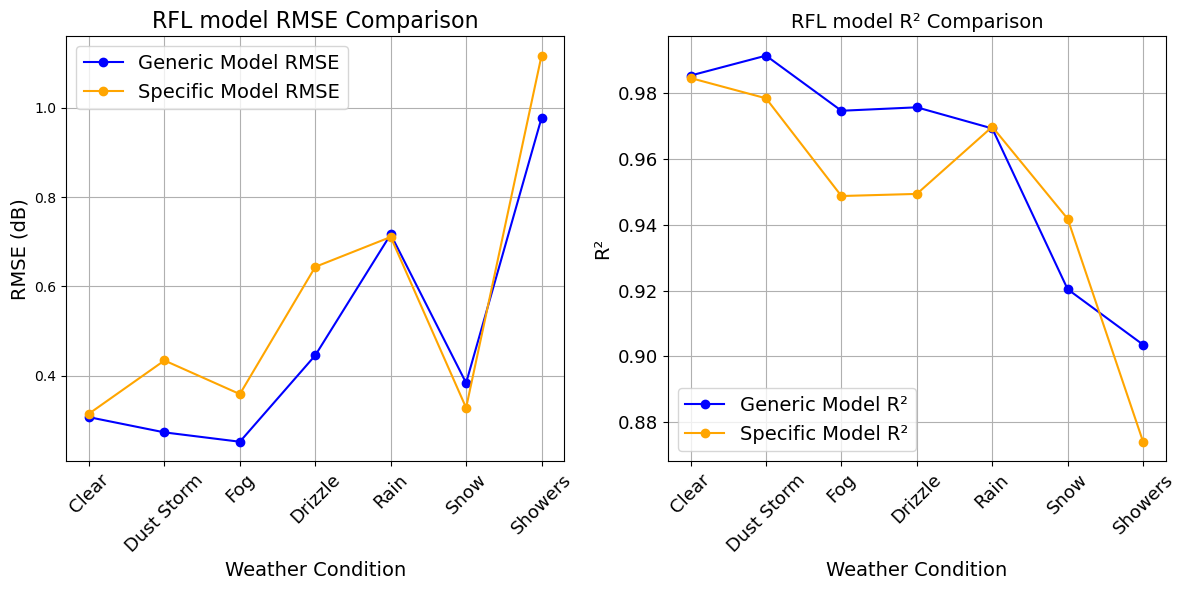

In [31]:
# Extract weather conditions
conditions = list(gene_condition_results.keys())

# Extract RMSE and R² values
gene_rmse = [gene_condition_results[condition]['RMSE'] for condition in conditions]
gene_r2 = [gene_condition_results[condition]['R²'] for condition in conditions]

spec_rmse = [spec_condition_results[condition]['RMSE'] for condition in conditions]
spec_r2 = [spec_condition_results[condition]['R²'] for condition in conditions]

# Set up the canvas
plt.figure(figsize=(12, 6))

# Plot RMSE
plt.subplot(1, 2, 1)
plt.plot(conditions, gene_rmse, marker='o', color='blue', label='Generic Model RMSE')
plt.plot(conditions, spec_rmse, marker='o', color='orange', label='Specific Model RMSE')
plt.title('RFL model RMSE Comparison', fontsize=16)
plt.xlabel('Weather Condition', fontsize=14)
plt.ylabel('RMSE (dB)', fontsize=14)
plt.xticks(rotation=45, fontsize=13)
plt.legend(fontsize=14)
plt.grid()

# Plot R²
plt.subplot(1, 2, 2)
plt.plot(conditions, gene_r2, marker='o', color='blue', label='Generic Model R²')
plt.plot(conditions, spec_r2, marker='o', color='orange', label='Specific Model R²')
plt.title('RFL model R² Comparison', fontsize=14)
plt.xlabel('Weather Condition', fontsize=14)
plt.ylabel('R²', fontsize=14)
plt.xticks(rotation=45, fontsize=13)
plt.yticks(fontsize=13) 
plt.legend(fontsize=14)
plt.grid()

# Display the plot
plt.tight_layout()
plt.show()

From the figures, we can find the generic model performs better than the specific model in clear, dust storm, fog, drizzle and showers weathers, as its RMSE is lower and r2 is higher. The specific model performs better in rain and snow weather. In overall metrics, we can find the generic model has the better performance.  This result aligns with the overall metrics, suggesting that the generic model is the best model for predicting RF attenuation.

In [32]:
# Compare RMSE and R² to select the best model
if rmse_test < speci_rmse and r2_test > speci_r2:
    best_model = "Generic RF Model"
else:
    best_model = "Specific Model"

# Output the best model's information
print(f'specific model: RMSE = {speci_rmse:.4f}, R² = {speci_r2:.4f}')
print(f'generic model: RMSE = {rmse_test:.4f}, R² = {r2_test:.4f}')
print(f"The best model is: {best_model}")

specific model: RMSE = 0.5050, R² = 0.9786
generic model: RMSE = 0.4824, R² = 0.9804
The best model is: Generic RF Model


In [33]:
X_test['SYNOPCode'].value_counts()

0    17089
6     7505
5     1982
8      515
4      140
7      126
3       57
Name: SYNOPCode, dtype: int64

In [34]:
# Generic and Specific model results
gene_condition_results
spec_condition_results 

# Initialise DataFrame to store results
weather_conditions = ['Clear', 'Dust Storm', 'Fog', 'Drizzle', 'Rain', 'Snow', 'Showers']
columns = ['RMSE Difference', 'RMSE Improvement (%)', 'R² Difference', 'R² Improvement (%)']

results_df = pd.DataFrame(index=weather_conditions, columns=columns)

# Calculate RMSE and R² differences and improvement percentages
for condition in weather_conditions:
    # Generic and Specific RMSE and R²
    gene_rmse = gene_condition_results[condition]['RMSE']
    spec_rmse = spec_condition_results[condition]['RMSE']
    
    gene_r2 = gene_condition_results[condition]['R²']
    spec_r2 = spec_condition_results[condition]['R²']
    
    # Difference
    rmse_diff = gene_rmse - spec_rmse
    r2_diff = gene_r2 - spec_r2  
    
    # Improvement percentage
    rmse_improvement_pct = - (rmse_diff / spec_rmse) * 100 
    r2_improvement_pct = (r2_diff / spec_r2) * 100
    
    # Fill the DataFrame
    results_df.loc[condition, 'RMSE Difference'] = round(rmse_diff, 3)
    results_df.loc[condition, 'RMSE Improvement (%)'] = round(rmse_improvement_pct, 3)
    
    results_df.loc[condition, 'R² Difference'] = round(r2_diff, 3)
    results_df.loc[condition, 'R² Improvement (%)'] = round(r2_improvement_pct, 3)

# Set display options to avoid automatic line breaks
pd.set_option('display.expand_frame_repr', False)  

# Set font size for better readability
plt.rcParams['font.size'] = 14 

# Add title to explain the difference
title = """
Table: RFL: Amount of Improvement Provided by the Generic Model Over the Specific Model 
- RMSE Difference: The difference between the Specific Model RMSE and Generic Model RMSE.
- RMSE Improvement (%): The percentage improvement in RMSE of the Generic Model over the Specific Model (positive values indicate improvement).
- R² Difference: The difference between the Generic Model R² and the Specific Model R².
- R² Improvement (%): The percentage improvement in R² of the Generic Model over the Specific Model (positive values indicate improvement).
"""

# Print title and table
print(title)
print(results_df)


Table: RFL: Amount of Improvement Provided by the Generic Model Over the Specific Model 
- RMSE Difference: The difference between the Specific Model RMSE and Generic Model RMSE.
- RMSE Improvement (%): The percentage improvement in RMSE of the Generic Model over the Specific Model (positive values indicate improvement).
- R² Difference: The difference between the Generic Model R² and the Specific Model R².
- R² Improvement (%): The percentage improvement in R² of the Generic Model over the Specific Model (positive values indicate improvement).

           RMSE Difference RMSE Improvement (%) R² Difference R² Improvement (%)
Clear               -0.008                2.514         0.001              0.077
Dust Storm          -0.161               37.129         0.013              1.328
Fog                 -0.107               29.764         0.026              2.736
Drizzle             -0.198                 30.8         0.026              2.777
Rain                 0.006               -